# Variational Autoencoder (VAE)

Useful links: 
* Original paper http://arxiv.org/abs/1312.6114
* Helpful videos explaining the topic 
   * https://www.youtube.com/watch?v=P78QYjWh5sM     
   * http://videolectures.net/deeplearning2015_courville_autoencoder_extension/?q=aaron%20courville

In this homework we will train an autoencoder to model images of faces. For this we take "Labeled Faces in the Wild" dataset (LFW) (http://vis-www.cs.umass.edu/lfw/), deep funneled version of it. (frontal view of all faces)


## Prepare the data

In [1]:
import numpy as np
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
import matplotlib.pyplot as plt
%matplotlib inline

**Collab setting**

In [2]:
# if you're running in colab,
# 1. go to Runtime -> Change Runtimy Type -> GPU
# 2. uncomment this:
#!wget https://raw.githubusercontent.com/yandexdataschool/Practical_DL/hw3_19/homework03/lfw_dataset.py -O lfw_dataset.py

In [3]:
# The following line fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind
from lfw_dataset import fetch_lfw_dataset
data,attrs = fetch_lfw_dataset(dimx=36,dimy=36)


In [4]:
data = data/255
np.savez("real.npz", Pictures=data.reshape(data.shape[0], 36*36*3))

In [5]:
X_train = data[:10000].reshape((10000, -1))
print(X_train.shape)
X_val = data[10000:].reshape((-1, X_train.shape[1]))
print(X_val.shape)

image_h = data.shape[1]
image_w = data.shape[2]

(10000, 3888)
(3143, 3888)


For simplicity we want all values of the data to lie in the interval $[0,1]$:

In [6]:
X_train = np.float32(X_train)
X_val = np.float32(X_val)

In [7]:
def plot_gallery(images, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.5 * n_col, 1.7 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w, 3)), cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')
        plt.xticks(())
        plt.yticks(())

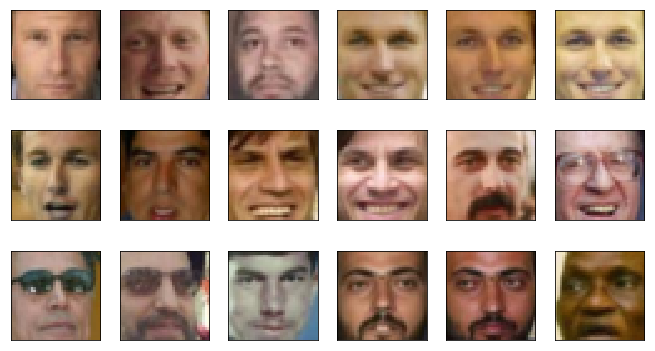

In [8]:
plot_gallery(X_train, image_h, image_w)

In [9]:
train = data_utils.TensorDataset(torch.Tensor(X_train), torch.zeros(X_train.shape[0],)) # pseudo labels needed to define TensorDataset
train_loader = data_utils.DataLoader(train, batch_size=100, shuffle=True)

val = data_utils.TensorDataset(torch.Tensor(X_val), torch.zeros(X_val.shape[0],))
val_loader = data_utils.DataLoader(val, batch_size=1, shuffle=False)

# Autoencoder

Why to use all this complicated formulaes and regularizations, what is the need for variational inference? To analyze the difference, let's first train just an autoencoder on the data:

<img src="Autoencoder_structure.png" alt="Autoencoder">

In [10]:
dimZ = 100 # Considering face reconstruction task, which size of representation seems reasonable?

# Define the decoder and encoder as networks with one hidden fc-layer
# (that means you will have 2 fc layers in each net)
# Use ReLU for hidden layers' activations
# GlorotUniform initialization for W
# Zero initialization for biases
# It's also convenient to put sigmoid activation on output layer to get nice normalized pics

class Autoencoder(nn.Module):
    def __init__(self, n_hidden = 350):
        super(Autoencoder, self).__init__()
            
        sample_size = 3*image_h*image_w
        self.encoder = nn.Sequential(nn.Dropout(p=.25),
                                     nn.Linear(sample_size, n_hidden),
                                     nn.BatchNorm1d(n_hidden),
                                     nn.ReLU(),
                                     nn.Linear(n_hidden, dimZ),
                                     nn.BatchNorm1d(dimZ)
                                    )
        self.decoder = nn.Sequential(nn.Linear(dimZ, n_hidden),
                                     nn.BatchNorm1d(n_hidden),
                                     nn.ReLU(),
                                     nn.Linear(n_hidden, sample_size),
                                     nn.Sigmoid()
                                    )
        
        # Initialize params
        def initialize_params(layer):
            if type(layer) == nn.Linear:
                nn.init.xavier_uniform_(layer.weight)
                layer.bias.data.fill_(0)
                
        self.apply(initialize_params)
        
    def forward(self, x):
        
        #TODO
        
        latent_code = self.encoder(x)
        reconstruction = self.decoder(latent_code)
        
        return reconstruction, latent_code

In [11]:
# Create MSE loss function
criterion = torch.nn.MSELoss()

autoencoder = Autoencoder().cuda()

# Use Adam optimizer
optimizer = optim.Adam(autoencoder.parameters())

In [12]:
# Train your autoencoder
# Visualize progress in reconstruction and loss decay

loss_train_history = []
loss_val_history = []
image_progress = []

def train_aec(model, criterion, optimizer, n_epochs=32, track=None):
    for epoch in range(n_epochs):
        losses_train = []
        losses_val = []
        
        # Train stage
        model.train()
        for _, batch in enumerate(train_loader):
            X = batch[0].cuda()
            optimizer.zero_grad()
            X_rec = model(X)[0]
            loss = criterion(X_rec, X)
            loss.backward()
            losses_train.append(loss.detach().cpu().numpy())
            optimizer.step()
            optimizer.zero_grad()
        loss_train_history.append(np.mean(losses_train))
        
        # Val stage
        model.eval()
        for _, batch in enumerate(val_loader):
            X = batch[0].cuda()
            with torch.no_grad():
                X_rec = model(X)[0]
            loss = criterion(X_rec, X)
            losses_val.append(loss.detach().cpu().numpy())
        loss_val_history.append(np.mean(losses_val))
        print("#%i, Train loss: %.7f, Val loss: %.7f"%(epoch+1,loss_train_history[-1],loss_val_history[-1]),flush=True)
        
        if track is not None and epoch % 5 == 0:
            with torch.no_grad():
                image_progress.append(model(track.cuda())[0])

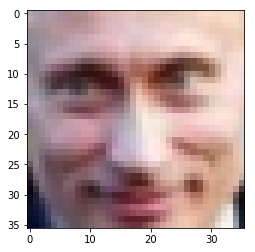

In [13]:
for i, (putin, y) in enumerate(val_loader):
    if i == 2754:
        break
plt.imshow(putin.numpy().reshape((image_w, image_w, 3)))

In [14]:
train_aec(autoencoder, criterion, optimizer, n_epochs=200, track=putin)

#1, Train loss: 0.0142856, Val loss: 0.0088777
#2, Train loss: 0.0081985, Val loss: 0.0073437
#3, Train loss: 0.0069654, Val loss: 0.0061324
#4, Train loss: 0.0062967, Val loss: 0.0055651
#5, Train loss: 0.0058853, Val loss: 0.0052061
#6, Train loss: 0.0056062, Val loss: 0.0049732
#7, Train loss: 0.0054316, Val loss: 0.0046241
#8, Train loss: 0.0051972, Val loss: 0.0047340
#9, Train loss: 0.0050530, Val loss: 0.0044327
#10, Train loss: 0.0049511, Val loss: 0.0041940
#11, Train loss: 0.0048464, Val loss: 0.0041386
#12, Train loss: 0.0047720, Val loss: 0.0040768
#13, Train loss: 0.0046873, Val loss: 0.0040778
#14, Train loss: 0.0046177, Val loss: 0.0040634
#15, Train loss: 0.0045559, Val loss: 0.0040254
#16, Train loss: 0.0044748, Val loss: 0.0037143
#17, Train loss: 0.0043881, Val loss: 0.0037747
#18, Train loss: 0.0044180, Val loss: 0.0036441
#19, Train loss: 0.0043919, Val loss: 0.0036060
#20, Train loss: 0.0043250, Val loss: 0.0038280
#21, Train loss: 0.0042933, Val loss: 0.0035779
#

#171, Train loss: 0.0033933, Val loss: 0.0027224
#172, Train loss: 0.0034008, Val loss: 0.0025843
#173, Train loss: 0.0033832, Val loss: 0.0027407
#174, Train loss: 0.0034099, Val loss: 0.0026459
#175, Train loss: 0.0033963, Val loss: 0.0025651
#176, Train loss: 0.0033984, Val loss: 0.0026447
#177, Train loss: 0.0033791, Val loss: 0.0025830
#178, Train loss: 0.0034038, Val loss: 0.0026261
#179, Train loss: 0.0033572, Val loss: 0.0026027
#180, Train loss: 0.0033937, Val loss: 0.0026726
#181, Train loss: 0.0034176, Val loss: 0.0025399
#182, Train loss: 0.0033585, Val loss: 0.0025904
#183, Train loss: 0.0033599, Val loss: 0.0025720
#184, Train loss: 0.0033921, Val loss: 0.0028911
#185, Train loss: 0.0033877, Val loss: 0.0025899
#186, Train loss: 0.0033791, Val loss: 0.0026191
#187, Train loss: 0.0033797, Val loss: 0.0025793
#188, Train loss: 0.0033611, Val loss: 0.0026508
#189, Train loss: 0.0034028, Val loss: 0.0026761
#190, Train loss: 0.0033591, Val loss: 0.0026374
#191, Train loss: 0.

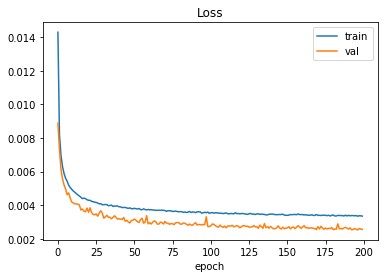

In [15]:
# Visualize loss decay
plt.figure()
plt.plot(loss_train_history, label="train")
plt.plot(loss_val_history, label="val")
plt.legend()
plt.title("Loss")
plt.xlabel("epoch")
plt.show()

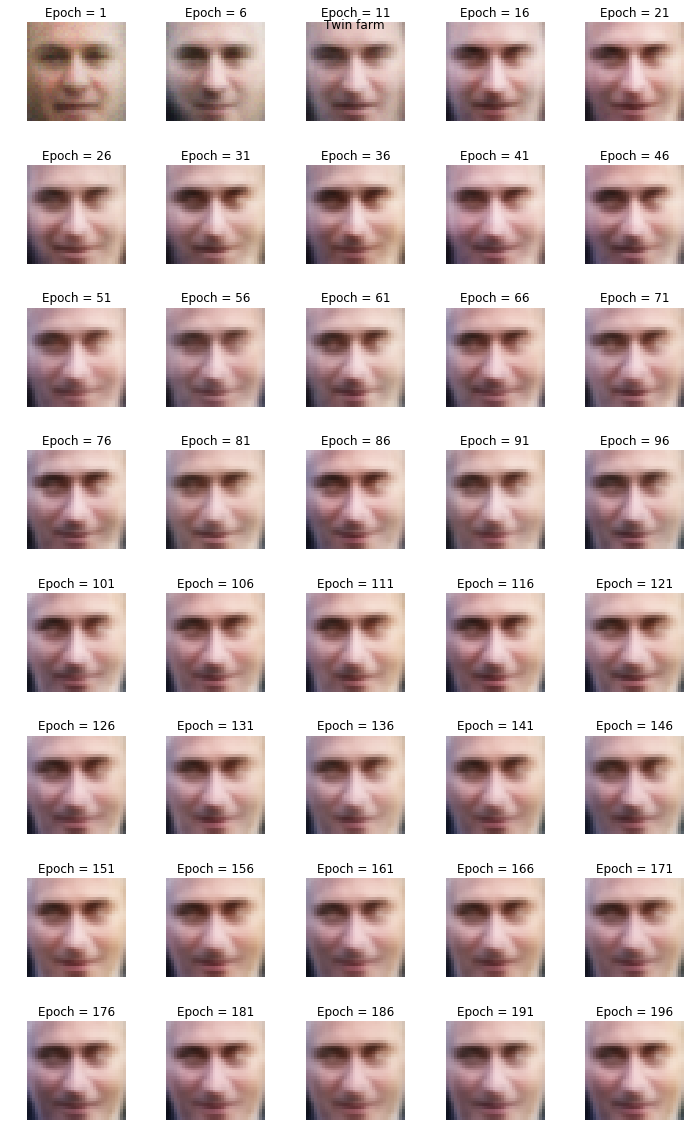

In [16]:
# Visualize progress in reconstruction
plt.figure(figsize=(10, 16))
plt.suptitle('Twin farm')
for i in range(len(image_progress[:40])):
    plt.subplots_adjust(bottom=0.0, left=.1, right=.9, top=.50, hspace=.15)
    plt.subplot(8, 5, 5*(i//5) + i % 5 + 1)
    plt.imshow(image_progress[i].clamp(0,1).data.cpu().numpy().reshape(image_w, image_h, 3))
    plt.title('Epoch = {}'.format(i * 5 + 1))
    plt.axis('off')
plt.tight_layout()

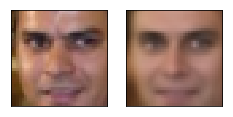

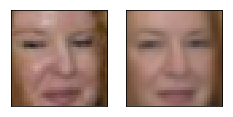

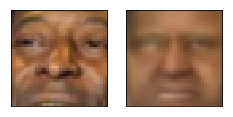

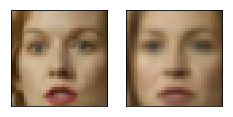

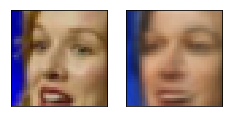

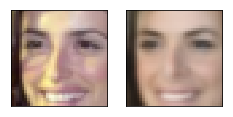

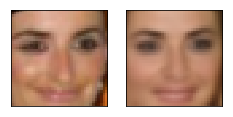

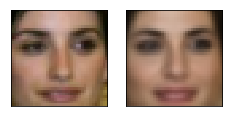

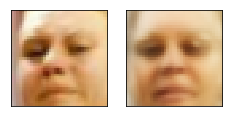

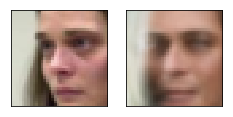

In [17]:
# Examine the reconstructions
for j, batch in enumerate(val_loader, 0):
    inp = Variable(batch[0].cuda())
    pred, _ = autoencoder(inp)
    plot_gallery([batch[0].numpy(), pred.data.cpu().numpy()], image_h, image_w, n_row=1, n_col=2)
    if (j >= 9):
        break

Reconstruction is not bad, right? 

### Answer:
Yes

# Sampling

Let's now sample several latent vectors and perform inference from $z$, reconstruct an image given some random $z$ representations.

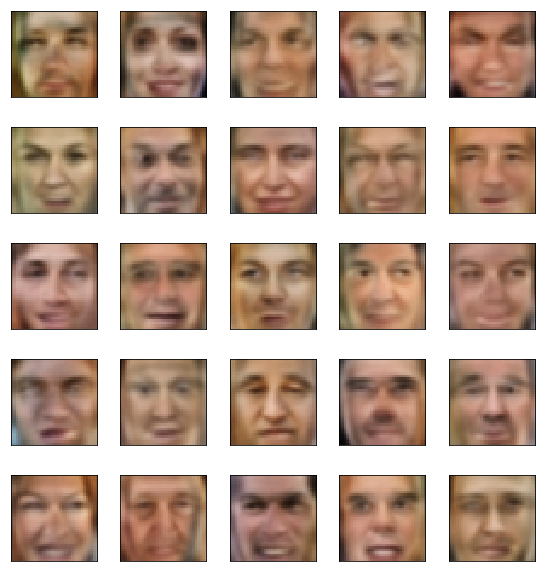

In [18]:
z = (np.random.randn(25, dimZ)*.5).astype('float32')
output = autoencoder.decoder(Variable(torch.from_numpy(z)).cuda()).clamp(0, 1)
plot_gallery(output.data.cpu().numpy(), image_h, image_w, n_row=5, n_col=5)

So, if we sample $z$ from normal, whould we eventually generate all possible faces? What do you think?

### Answer:
No. While we can generate faces with many different combinations of the features encoded with the latent representation, there may be more real-life face features, that the vector can fit. Also, some features may be underrepresented in the dataset and/or not learned during training. So, some realistic images may not exist in the latent space. Also, some "creepy", not natural faces can be generated this way because realistic faces are not distributed normally in the latent space.

# Variational Autoencoder

Bayesian approach in deep learning considers everything in terms of distributions. Now our encoder generates not just a vector $z$ but posterior ditribution $q(z|x)$. In our case distribution $q$ is Gaussian distibution $N(\mu, \sigma)$ with parameters $\mu$, $\sigma$. Technically, the first difference is that you need to split bottleneck layer in two. One dense layer will generate vector $\mu$, and another will generate vector $\sigma$. Reparametrization trick should be implemented using the **gaussian_sampler** layer, that generates random vetor $\epsilon$ and returns $\mu+\sigma\epsilon \sim N(\mu, \sigma)$ .

Since our decoder is also a function that generates distribution, we need to do the same splitting for output layer. When testing the model we will look only on mean values, so one of the output will be actual autoencoder output.

In this homework we only ask for implementation of the simplest version of VAE - one $z$ sample per input. You can consider to sample several outputs from one input and average them.

In [19]:
# to compare with conventional AE, keep these hyperparameters
# or change them for the values that you used before
dimZ = 100

# define the network
# you can start from https://github.com/pytorch/examples/blob/master/vae/main.py
# or Theano-based examples here https://github.com/Lasagne/Recipes/blob/master/examples/variational_autoencoder/variational_autoencoder.py
# and here https://github.com/y0ast/Variational-Autoencoder/blob/master/VAE.py
# but remember that this is not your ground truth since the data is not MNIST

class VAE(nn.Module):
    def __init__(self, n_hidden=250):
        super(VAE, self).__init__()
        
        #TODO
        sample_size = 3*image_h*image_w
        
        self.drop = nn.Dropout(p=.25)
        self.fc1 = nn.Linear(sample_size, n_hidden)
        self.bn_in = nn.BatchNorm1d(n_hidden)
        self.fc2_mu = nn.Linear(n_hidden, dimZ)
        self.fc2_logsigma = nn.Linear(n_hidden, dimZ)
        self.fc3 = nn.Linear(dimZ, n_hidden)
        self.bn_out = nn.BatchNorm1d(n_hidden)
        self.fc4_mu = nn.Linear(n_hidden, sample_size)
        self.fc4_logsigma = nn.Linear(n_hidden, sample_size)
        
        # Initialize params
        def initialize_params(layer):
            if type(layer) == nn.Linear:
                nn.init.xavier_uniform_(layer.weight, gain=0.1) # default gain was too big (unstable loss)
                layer.bias.data.fill_(0)
                
        self.apply(initialize_params)
        
    def encode(self, x):
        x = self.drop(x)
        h = F.relu(self.bn_in(self.fc1(x)))
        return self.fc2_mu(h), self.fc2_logsigma(h)
    
    def decode(self, z):
        h = F.relu(self.bn_out(self.fc3(z)))
        return self.fc4_mu(h), self.fc4_logsigma(h)
    
    def gaussian_sampler(self, mu, logsigma):
        if self.training:
#             std = logsigma.exp_()
#             eps = Variable(std.data.new(std.size()).normal_())
#             return eps.mul(std).add_(mu)
            std = torch.exp(logsigma)
            eps = torch.randn_like(std) 
            return mu + eps * std
        else:
            return mu

    def forward(self, x):
        
        #TODO
        latent_mu, latent_logsigma = self.encode(x)
        z = self.gaussian_sampler(latent_mu, latent_logsigma)
        reconstruction_mu, reconstruction_logsigma = self.decode(z)
        return reconstruction_mu, reconstruction_logsigma, latent_mu, latent_logsigma

And the last, but not least! Place in the code where the most of the formulaes goes to - optimization objective. The objective for VAE has it's own name - variational lowerbound. And as for any lowerbound our intention is to maximize it. Here it is (for one sample $z$ per input $x$):

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p_{\theta}(z)) + \log p_{\theta}(x|z)$$

Your next task is to implement two functions that compute KL-divergence and the second term - log-likelihood of an output. Here is some necessary math for your convenience:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$
$$\log p_{\theta}(x|z) = \sum_{i=1}^{dimX}\log p_{\theta}(x_i|z)=\sum_{i=1}^{dimX} \log \Big( \frac{1}{\sigma_i\sqrt{2\pi}}e^{-\frac{(\mu_I-x)^2}{2\sigma_i^2}} \Big)=...$$

Don't forget in the code that you are using $\log\sigma$ as variable. Explain, why not $\sigma$?

### Answer:
The encoding network predicts $\log\sigma$ to use full range of natural numbers. $\sigma$ can not be negative, so $\log\sigma$ is better for a net (or layer) output.

In [20]:
def KL_divergence(mu, logsigma):
    return (-.5 - logsigma + .5 * mu**2 + .5 * logsigma.exp()**2).sum(dim=1).mean()

def log_likelihood(x, mu, logsigma):
    return (-.5 * np.log(2 * np.pi) - logsigma - .5 * (mu - x)**2 / logsigma.exp()**2).sum(dim=1).mean()

def loss_vae(x, mu_gen, logsigma_gen, mu_z, logsigma_z):
    L = -KL_divergence(mu_z, logsigma_z) + log_likelihood(x, mu_gen, logsigma_gen)
    return -L # negation, since we want to maximize L

And train the model:

In [21]:
# train your autoencoder
# visualize progress in reconstruction and loss decay

loss_train_history = []
loss_val_history = []
image_progress = []

def train_vae(model, optimizer, n_epochs=32, track=None):
    for epoch in range(n_epochs):
        losses_train = []
        losses_val = []
        
        # Train stage
        model.train()
        for _, batch in enumerate(train_loader):
            X = batch[0].cuda()
            optimizer.zero_grad()
            mu_gen, logsigma_gen, mu_z, logsigma_z = model(X)
            loss = loss_vae(X, mu_gen, logsigma_gen, mu_z, logsigma_z)
            loss.backward()
            losses_train.append(loss.detach().cpu().numpy())
            optimizer.step()
            optimizer.zero_grad()
        loss_train_history.append(np.mean(losses_train))
        
        # Val stage
        model.eval()
        for _, batch in enumerate(val_loader):
            X = batch[0].cuda()
            with torch.no_grad():
                mu_gen, logsigma_gen, mu_z, logsigma_z = model(X)
            loss = loss_vae(X, mu_gen, logsigma_gen, mu_z, logsigma_z)
            losses_val.append(loss.detach().cpu().numpy())
        loss_val_history.append(np.mean(losses_val))
        print("#%i, Train loss: %.7f, Val loss: %.7f"%(epoch+1,loss_train_history[-1],loss_val_history[-1]),flush=True)
        
        if track is not None and epoch % 5 == 0:
            with torch.no_grad():
                image_progress.append(model(track.cuda())[0])

In [22]:
vae = VAE().cuda()
optimizer = optim.Adam(vae.parameters(), lr=1e-4)
train_vae(vae, optimizer, n_epochs=200, track=putin)

#1, Train loss: 2960.4421387, Val loss: 3332.9189453
#2, Train loss: 615.9774780, Val loss: 2511.5742188
#3, Train loss: -1164.3492432, Val loss: 1798.7391357
#4, Train loss: -2115.0852051, Val loss: 1176.3813477
#5, Train loss: -2441.5549316, Val loss: 872.1529541
#6, Train loss: -2640.2932129, Val loss: 591.4498901
#7, Train loss: -2743.8210449, Val loss: 172.5663452
#8, Train loss: -2842.2705078, Val loss: 112.0469666
#9, Train loss: -2947.5397949, Val loss: 7.7687111
#10, Train loss: -3006.7836914, Val loss: -309.6871948
#11, Train loss: -3068.9084473, Val loss: -510.3386841
#12, Train loss: -3149.5817871, Val loss: -689.1755981
#13, Train loss: -3196.8986816, Val loss: -702.3548584
#14, Train loss: -3270.1621094, Val loss: -944.1920166
#15, Train loss: -3332.5087891, Val loss: -1189.2032471
#16, Train loss: -3374.9020996, Val loss: -1422.5832520
#17, Train loss: -3426.8212891, Val loss: -1505.4498291
#18, Train loss: -3474.2705078, Val loss: -1704.1802979
#19, Train loss: -3523.56

#148, Train loss: -5130.1113281, Val loss: -5497.5083008
#149, Train loss: -5115.1000977, Val loss: -5427.0708008
#150, Train loss: -5137.1757812, Val loss: -5456.2617188
#151, Train loss: -5156.4345703, Val loss: -5478.2768555
#152, Train loss: -5157.8364258, Val loss: -5508.5620117
#153, Train loss: -5146.2163086, Val loss: -5487.2363281
#154, Train loss: -5151.3344727, Val loss: -5483.5820312
#155, Train loss: -5156.3525391, Val loss: -5479.8618164
#156, Train loss: -5125.9233398, Val loss: -5486.9887695
#157, Train loss: -5168.2714844, Val loss: -5506.8266602
#158, Train loss: -5154.0385742, Val loss: -5495.2250977
#159, Train loss: -5183.9995117, Val loss: -5506.9135742
#160, Train loss: -5172.8374023, Val loss: -5531.4692383
#161, Train loss: -5171.7817383, Val loss: -5492.5922852
#162, Train loss: -5177.4169922, Val loss: -5497.9511719
#163, Train loss: -5166.4008789, Val loss: -5509.3696289
#164, Train loss: -5174.5761719, Val loss: -5558.6630859
#165, Train loss: -5176.0996094

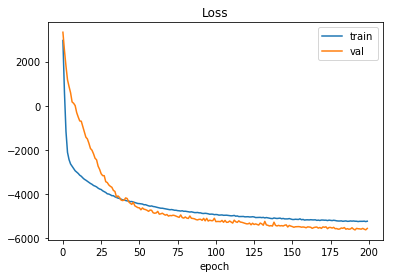

In [23]:
# Visualize loss decay
plt.figure()
plt.plot(loss_train_history, label="train")
plt.plot(loss_val_history, label="val")
plt.legend()
plt.title("Loss")
plt.xlabel("epoch")
plt.show()

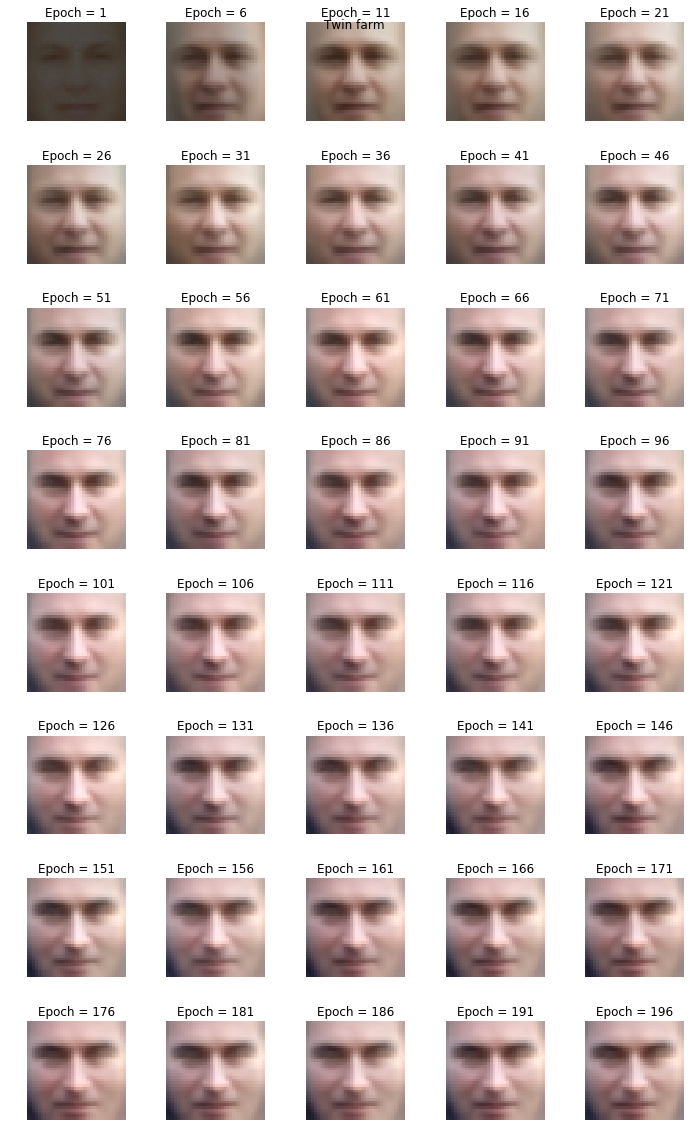

In [24]:
# Visualize progress in reconstruction
plt.figure(figsize=(10, 16))
plt.suptitle('Twin farm')
for i in range(len(image_progress[:40])):
    plt.subplots_adjust(bottom=0.0, left=.1, right=.9, top=.50, hspace=.15)
    plt.subplot(8, 5, 5*(i//5) + i % 5 + 1)
    plt.imshow(image_progress[i].clamp(0,1).data.cpu().numpy().reshape(image_w, image_h, 3))
    plt.title('Epoch = {}'.format(i * 5 + 1))
    plt.axis('off')
plt.tight_layout()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/home/viktor/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


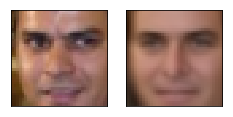

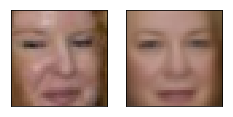

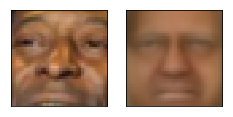

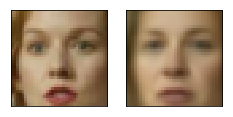

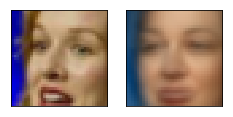

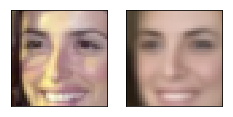

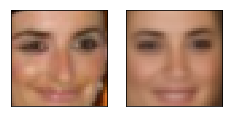

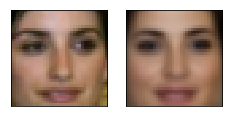

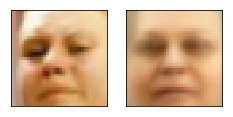

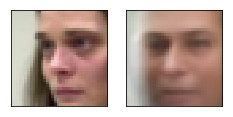

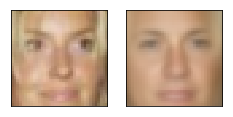

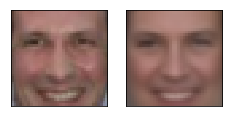

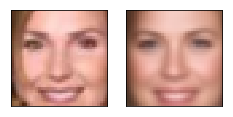

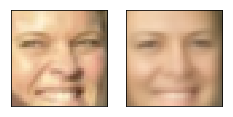

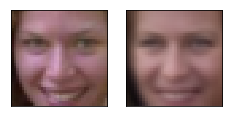

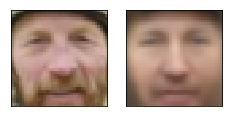

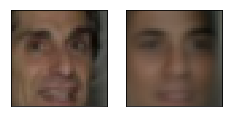

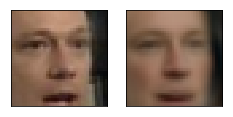

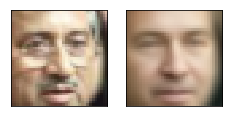

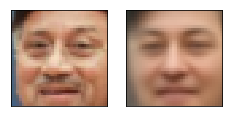

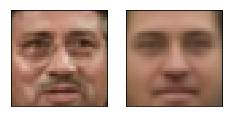

In [25]:
# Examine the reconstructions
for j, batch in enumerate(val_loader, 0):
    inp = Variable(batch[0].cuda())
    pred, _, _, _ = vae(inp)
    plot_gallery([batch[0].numpy(), pred.data.cpu().numpy()], image_h, image_w, n_row=1, n_col=2)
    if (j >= 20):
        break

And finally sample from VAE.

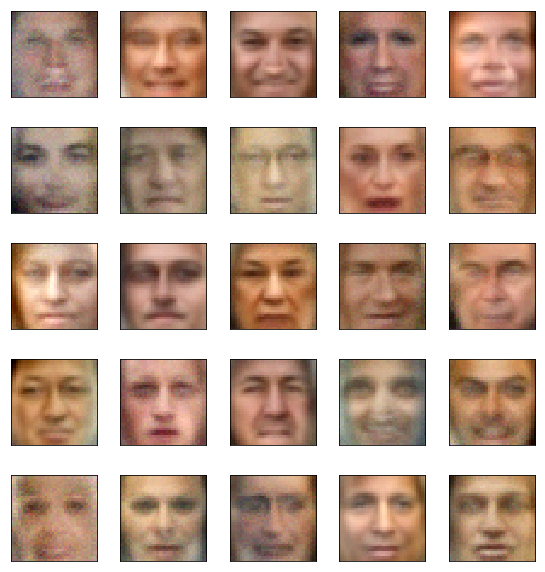

In [26]:
# TODO
# Sample some images from the learned distribution
# 1) Sample z ~ N(0,1)
# 2) Sample from N(decoder_mu(z), decoder_sigma(z))

z = np.random.randn(25, dimZ).astype('float32')
mu, logsigma = vae.decode(torch.from_numpy(z).cuda())
generated_images = mu.data.cpu().numpy() + np.random.rand(*logsigma.shape) * logsigma.exp().data.cpu().numpy()
generated_images = generated_images.clip(0, 1)
plot_gallery(generated_images, image_h, image_w, n_row=5, n_col=5)

Even if in practice you do not see the much difference between AE and VAE, or VAE is even worse, the little bayesian inside you should be jumping for joy right now. 

In VAE you can truly sample from image distribution $p(x)$, while in AE there is no easy and correct way to do it. 

## If you are going to do part 4 (presicion-recall score): 

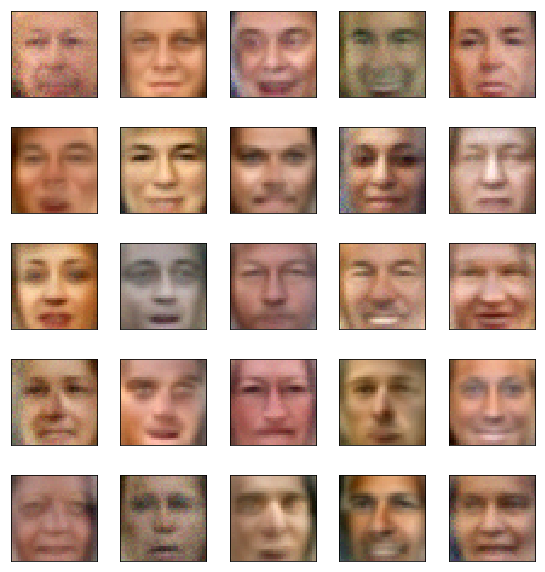

In [27]:
# using your model, generate face set with len = len(data)

z = np.random.randn(len(data), dimZ).astype('float32')
mu, logsigma = vae.decode(torch.from_numpy(z).cuda())
generated_images = mu.data.cpu().numpy() + np.random.rand(*logsigma.shape) * logsigma.exp().data.cpu().numpy()
generated_images = generated_images.clip(0, 1)
plot_gallery(generated_images, image_h, image_w, n_row=5, n_col=5)

answ = generated_images

## Save it ot npz

In [28]:
np.savez("vae.npz", Pictures=answ)

# Congrats! and Bonus

If you managed to tune your autoencoders to converge and learn something about the world, now it's time to make fun out of it. As you may have noticed, there are face attributes in dataset. We're interesting in "Smiling" column, but feel free to try others as well! Here is the first task:

1) Extract the "Smilling" attribute and create a two sets of images: 10 smiling faces and 10 non-smiling ones.

2) Compute latent representations for each image in "smiling" set and average those latent vectors. Do the same for "non-smiling" set. You have found **"vector representation"** of the "smile" and "no smile" attribute.

3) Compute the difference: "smile" vector minus "non-smile" vector.

3) Now check if **"feature arithmetics"** works. Sample a face without smile, encode it and add the diff from p. 3. Check if it works with both AE and VAE. 

<img src="linear.png" alt="linear">

In [29]:
smiling_attr = attrs['Smiling'].values
smiling_attr = smiling_attr[:10000] # train dataset
smiling_ranking = smiling_attr.argsort()
smiling_images = X_train[smiling_ranking[-10:]]
non_smiling_images = X_train[smiling_ranking[:10]]

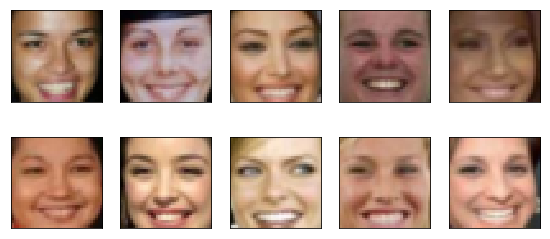

In [30]:
# Smiling
plot_gallery(smiling_images, image_h, image_w, n_row=2, n_col=5)

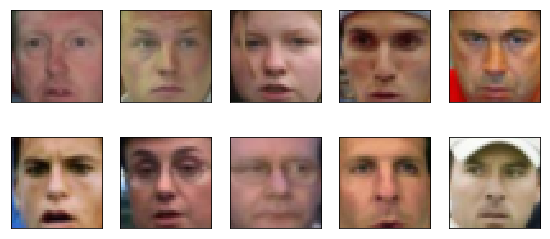

In [31]:
# Non-smiling
plot_gallery(non_smiling_images, image_h, image_w, n_row=2, n_col=5)

In [32]:
def arithmetics_check(model, non_smiling_image, n = 7):
    # Encode
    if model.__class__ == VAE:
        smiling_images_latent, _ = model.encode(torch.tensor(smiling_images).cuda())
        non_smiling_images_latent, _ = model.encode(torch.tensor(non_smiling_images).cuda())
        non_smiling_image_latent, _ = model.encode(torch.tensor(non_smiling_image).cuda())
    else:
        smiling_images_latent = model.encoder(torch.tensor(smiling_images).cuda())
        non_smiling_images_latent = model.encoder(torch.tensor(non_smiling_images).cuda())
        non_smiling_image_latent = model.encoder(torch.tensor(non_smiling_image).cuda())
    # Diff
    smile = smiling_images_latent.mean(dim=0, keepdim=True)
    no_smile = non_smiling_images_latent.mean(dim=0, keepdim=True)
    diff = smile - no_smile
    # Apply diff
    images = []
    for i in range(n):
        no_smile_plus_diff_latent = non_smiling_image_latent + diff * i / (n - 1)
        # Decode
        if model.__class__ == VAE:
            no_smile_plus_diff, _ = vae.decode(no_smile_plus_diff_latent)
        else:
            no_smile_plus_diff = model.decoder(no_smile_plus_diff_latent)
        no_smile_plus_diff = no_smile_plus_diff.clamp(0, 1).detach().cpu()
        images.append(no_smile_plus_diff)
    images = torch.cat(images)
    # Show
    plot_gallery(images, image_h, image_w, n_row=1, n_col=n)

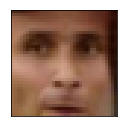

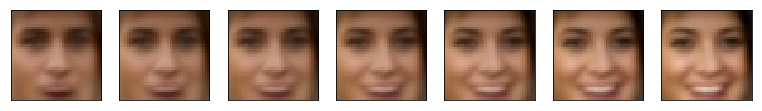

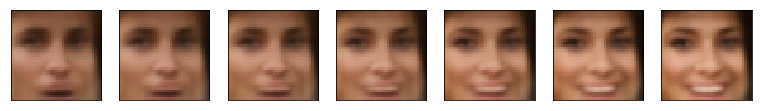

In [33]:
# Sample another non-smiling image to test feature arithmetics
n = 30
non_smiling_image = X_train[[smiling_ranking[n]]]
plot_gallery(non_smiling_image, image_h, image_w, n_row=1, n_col=1)

arithmetics_check(vae, X_train[[smiling_ranking[n]]])
arithmetics_check(autoencoder, X_train[[smiling_ranking[n]]])

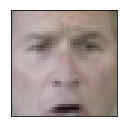

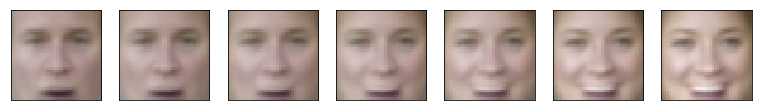

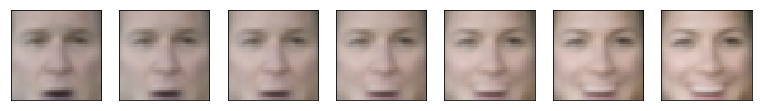

In [34]:
# Sample another non-smiling image to test feature arithmetics
n = 24
non_smiling_image = X_train[[smiling_ranking[n]]]
plot_gallery(non_smiling_image, image_h, image_w, n_row=1, n_col=1)

arithmetics_check(vae, X_train[[smiling_ranking[n]]])
arithmetics_check(autoencoder, X_train[[smiling_ranking[n]]])

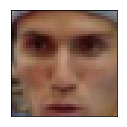

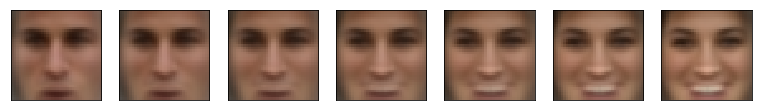

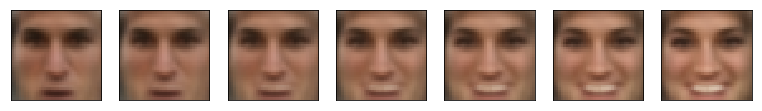

In [35]:
# Sample yet another non-smiling image to test feature arithmetics
# This time, one of those ten used for caluculating diff
n = 3
non_smiling_image = X_train[[smiling_ranking[n]]]
plot_gallery(non_smiling_image, image_h, image_w, n_row=1, n_col=1)

arithmetics_check(vae, X_train[[smiling_ranking[n]]])
arithmetics_check(autoencoder, X_train[[smiling_ranking[n]]])